# Topic analysis of the click event

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from empath import Empath
lexicon = Empath()

In [2]:
import codecs
import json
import random

records = []

file = codecs.open("link_level_pos_neg_clicks.json", "r", "utf-8")
counter = 0
for line in file:
    if random.randint(0, 10) < 5:
        tmp = line.replace("\n", " ").replace("\x85", " ")
        try:
            records.append(json.loads(tmp))
        except:
            counter += 0

In [3]:
len(records)

1649142

# Get Empath vectors

In [ ]:
topics = []
for r in records:
    if "top_macrotopic" in r:
        t = lexicon.analyze(r['reference_text'], normalize=True)
        t["top_macrotopic"] = r['top_macrotopic']
        t["click"] = r['click']
        topics.append(t)

# For each topic, get difference from positive and negative

In [13]:
df = pd.DataFrame(topics)

pos = df[df.click==1].drop("click", axis=1).mean().reset_index().rename(columns={"index": "name", 0: "positive"})
neg = df[df.click==0].drop("click", axis=1).mean().reset_index().rename(columns={"index": "name", 0: "negative"})
by_topic = pos.merge(neg, on="name")
by_topic["diff"]=by_topic['positive']-by_topic['negative']
by_topic.head(3)

,name,positive,negative,diff
0,help,0.000307,0.000343,-0.000036
1,office,0.000717,0.000714,0.000003
2,dance,0.000446,0.000410,0.000036


In [15]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

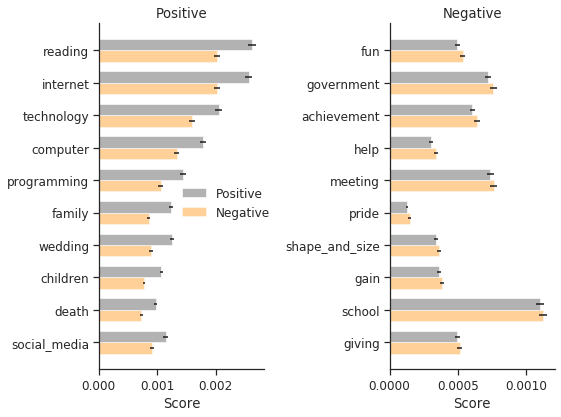

In [40]:
import numpy as np
import matplotlib.pyplot as plt


sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

######
topK = by_topic.sort_values("diff", ascending=False).head(10).name.tolist()
top_topics = df[topK+['click']]
top_topics_positive = top_topics[top_topics.click==1]
top_topics_negative = top_topics[top_topics.click==0]

pos = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_positive[f])
    pos.append({"name": f, "mean": m, "ci": ci})
    
pos = pd.DataFrame(pos)

neg = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_negative[f])
    neg.append({"name": f, "mean": m, "ci": ci})
    
neg = pd.DataFrame(neg)


labels = topK.copy()
labels.reverse()
positiveMeans = pos['mean'].tolist()
positiveStd = pos.ci.tolist()
positiveMeans.reverse()
positiveStd.reverse()
negativeMeans = neg['mean'].tolist()
negativeStd = neg.ci.tolist()
negativeMeans.reverse()
negativeStd.reverse()

ind = np.arange(len(labels))    # the x locations for the groups
width = 0.35         # the width of the bars
p2 = ax[0].barh(ind , negativeMeans, width, xerr=negativeStd, alpha=0.4, color="darkorange")
p1 = ax[0].barh(ind+ width, positiveMeans, width, xerr=positiveStd, alpha=0.6, color="grey")
ax[0].set_yticks(ind + width / 2)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel("Score")
ax[0].set_title("Positive")

ax[0].autoscale_view()


##################


topK = by_topic.sort_values("diff", ascending=True).head(10).name.tolist()
top_topics = df[topK+['click']]
top_topics_positive = top_topics[top_topics.click==1]
top_topics_negative = top_topics[top_topics.click==0]

pos = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_positive[f])
    pos.append({"name": f, "mean": m, "ci": ci})
    
pos = pd.DataFrame(pos)

neg = []

for f in topK:
    m, ci = mean_confidence_interval(top_topics_negative[f])
    neg.append({"name": f, "mean": m, "ci": ci})
    
neg = pd.DataFrame(neg)


labels = topK.copy()
labels.reverse()
positiveMeans = pos['mean'].tolist()
positiveStd = pos.ci.tolist()
positiveMeans.reverse()
positiveStd.reverse()
negativeMeans = neg['mean'].tolist()
negativeStd = neg.ci.tolist()
negativeMeans.reverse()
negativeStd.reverse()

ind = np.arange(len(labels))    # the x locations for the groups
width = 0.35         # the width of the bars
p2 = ax[1].barh(ind , negativeMeans, width, xerr=negativeStd, alpha=0.4, color="darkorange")
p1 = ax[1].barh(ind+ width, positiveMeans, width, xerr=positiveStd, alpha=0.6, color="grey")
ax[1].set_yticks(ind + width / 2)
ax[1].set_yticklabels(labels)
ax[1].set_xlabel("Score")
ax[1].set_title("Negative")

# ax[1].legend((p1[0], p2[0]), ('Hover', 'No Hover'))
ax[1].autoscale_view()

# leg = ax[1].legend((p1[0], p2[0]), ('Click', 'No Click'))
leg=ax[0].legend((p1[0], p2[0]), ('Positive', 'Negative'), bbox_to_anchor=(0.50,0.45), 
             loc="lower right",  bbox_transform=fig.transFigure)
leg.get_frame().set_linewidth(0.0)

# leg = .legend()
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

# plt.show()
plt.savefig('click_topics_ref.pdf', bbox_inches='tight')


------------